Minta:
 - legdrágább 1% kidob
 - ha többen (user) használnak egy számot akkor kidob
 - ha többen (agency) használnak egy számot akkor kidob
 - vezetékes, külföldi, ismeretlen számok kidob

In [1]:
from src.ingatlan import (
    property_table,
    seller_table,
    parking_table,
    price_table,
    heating_table,
    utility_cost_table,
    contact_table,
    label_table,
    location_table,
    property_rec_table,
)
from tqdm import tqdm

tqdm.pandas()

from src.meta import (
    Contact,
    Heating,
    Label,
    Parking,
    Price,
    RealEstate,
    RealEstateRecord,
    Seller,
    UtilityCost,
    Location,
)
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import json
from pathlib import Path


In [2]:
property_df = (
    property_table.get_full_df(env="complete")
    .applymap(lambda x: None if x == "None" else x)
    .loc[lambda _df: ~_df.index.duplicated(keep="first"), :]
)
seller_df = (
    seller_table.get_full_df(env="complete")
    .applymap(lambda x: None if x == "None" else x)
    .loc[lambda _df: ~_df.index.duplicated(keep="first"), :]
)
price_df = (
    price_table.get_full_df(env="complete")
    .applymap(lambda x: None if x == "None" else x)
    .loc[lambda _df: ~_df.index.duplicated(keep="first"), :]
)
contact_df = (
    contact_table.get_full_df(env="complete")
    .applymap(lambda x: None if x == "None" else x)
    .loc[lambda _df: ~_df.index.duplicated(keep="first"), :]
)
location_df = (
    location_table.get_full_df(env="complete")
    .applymap(lambda x: None if x == "None" else x)
    .loc[lambda _df: ~_df.index.duplicated(keep="first"), :]
)
property_rec_df = property_rec_table.get_full_df(env="complete").applymap(
    lambda x: None if x == "None" else x
)


In [3]:
proc_price_df = (
    price_df.reset_index()
    .assign(
        **{
            Price.amount: lambda _df: (
                (
                    _df[Price.interval_d] * _df[Price.amount] * 30
                    + _df[Price.interval_m] * _df[Price.amount]
                    + _df[Price.interval_y] * _df[Price.amount] / 12
                )
                / 100_000
            )
        }
    )
    .loc[lambda _df: _df[Price.currency] == "HUF", [Price.property_id.id, Price.amount]]
    .set_index(Price.property_id.id)
    .rename(columns={"amount": "price"})
)


In [4]:
current_ads = (
    property_rec_df.reset_index(RealEstateRecord.recorded)
    .loc[
        lambda _df: (
            _df[RealEstateRecord.recorded].dt.date
            == dt.datetime.now().date() - dt.timedelta(days=10)
        ),  # TODO
        :,
    ]
    .index.drop_duplicates()
)
current_ads.shape


(23845,)

In [5]:
valid_contacts = (
    pd.merge(
        contact_df.reset_index(),
        property_df[[RealEstate.seller_id.id]],
        left_on=Contact.property_id.id,
        right_index=True,
    )
    .drop_duplicates(subset=[RealEstate.seller_id.id, Contact.phone_number])
    .groupby(Contact.phone_number)
    .filter(lambda _gdf: _gdf[RealEstate.seller_id.id].nunique() == 1)
    .drop(columns=Contact.property_id.id)
    .drop_duplicates(subset=[RealEstate.seller_id.id], keep="first")
    .set_index(RealEstate.seller_id.id)
)


In [6]:
PLACES_NAMING = json.loads(Path("place_names.json").read_text())


def find_boundary_type(loc_df, loc_id, loc_type):
    parent = loc_df.loc[loc_id, :]
    if parent[Location.type] == loc_type:
        return parent.name
    else:
        return find_boundary_type(loc_df, parent[Location.parent_id], loc_type)


def generate_location_string(loc_df, loc_id):
    if loc_df.loc[loc_id, Location.type] == "poi":
        return generate_location_string(
            loc_df, find_boundary_type(loc_df, loc_id, "street")
        )
    if loc_df.loc[loc_id, Location.type] == "street":
        city = find_boundary_type(loc_df, loc_id, "city")
        if city == 11:
            district = find_boundary_type(loc_df, loc_id, "district")
            city_name = f"{loc_df.loc[district, Location.name]} {loc_df.loc[district, Location.name_postfix]}"
        else:
            city_name = f"{loc_df.loc[city, Location.name]} {loc_df.loc[city, Location.name_postfix]}"
        address_name = f"{loc_df.loc[loc_id, Location.name]} {PLACES_NAMING[loc_df.loc[loc_id, Location.name_postfix]]}"
        return f"{city_name} {address_name}"
    else:
        if not loc_df.loc[loc_id, Location.inflection_from] in ((None, "")):
            city_name = loc_df.loc[loc_id, Location.inflection_from]
        else:
            city_name = f"{loc_df.loc[loc_id, Location.name]}i".lower()
        return city_name


In [7]:
proc_property_df = property_df.loc[lambda _df: _df.index.intersection(current_ads), :]
proc_property_df.shape


(23842, 55)

In [8]:
final_df = (
    proc_property_df.merge(
        (
            seller_df.loc[:, [Seller.agency, Seller.name]].assign(
                is_agency=lambda _df: ~_df[Seller.agency].isna()
            )
        ),
        left_on=RealEstate.seller_id.id,
        right_index=True,
        how="inner",
    )
    .merge(proc_price_df, left_index=True, right_on=Price.property_id.id, how="inner")
    .merge(
        valid_contacts, left_on=RealEstate.seller_id.id, right_index=True, how="inner"
    )
    .assign(
        address=lambda _df: _df[RealEstate.location_id.id].progress_apply(
            lambda x: generate_location_string(location_df, x)
        ),
        city_code=lambda _df: _df[RealEstate.location_id.id].progress_apply(
            lambda x: find_boundary_type(location_df, x, "city")
        ),
        city_name=lambda _df: _df["city_code"].progress_apply(
            lambda x: location_df.loc[x, "name"]
        ),
    )
    .loc[
        :,
        [
            RealEstate.reference_id,
            RealEstate.seller_id.id,
            RealEstate.location_id.id,
            RealEstate.condition,
            RealEstate.area_size,
            RealEstate.type,
            "price",
            "address",
            Contact.phone_number,
            Seller.agency,
            Seller.name,
            "is_agency",
            "city_code",
            "city_name",
        ],
    ]
)

final_df.shape


100%|██████████| 17568/17568 [00:00<00:00, 100236.61it/s]


(17568, 14)

In [9]:
import seaborn as sns

In [10]:
final_df

,reference_id,seller_id__id,location_id__id,condition,area_size,type,price,address,phone_number,agency,name,is_agency,city_code,city_name
property_id__id,,,,,,,,,,,,,,
33455225,None,95476,135711,newlyBuilt,45.0,flat,250.0,XIV. kerület Egressy úti,+36 30 811 8112,Eagle Home Center,Eagle Home Center,True,11,Budapest
33454394,None,95476,32732,renovated,40.0,flat,150.0,VIII. kerület Baross utcai,+36 30 811 8112,Eagle Home Center,Eagle Home Center,True,11,Budapest
33455358,None,95476,40327,newlyBuilt,45.0,flat,200.0,IX. kerület Tűzoltó utcai,+36 30 811 8112,Eagle Home Center,Eagle Home Center,True,11,Budapest
33454455,None,95476,32731,renovated,40.0,flat,145.0,VIII. kerület Baross utcai,+36 30 811 8112,Eagle Home Center,Eagle Home Center,True,11,Budapest
33455262,None,95476,135767,renovated,40.0,flat,175.0,VII. kerület Erzsébet körúti,+36 30 811 8112,Eagle Home Center,Eagle Home Center,True,11,Budapest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33194267,None,200228526,8549,renovated,82.0,flat,99.0,Kalocsa Kunszt József utcai,+36 70 613 6823,None,nan,False,1368,Kalocsa
31974635,None,200897165,34206,renovated,105.0,flat,1400.0,V. kerület Falk Miksa utcai,+36 30 278 2962,None,nan,False,11,Budapest
33166878,None,103773,136307,inGoodCondition,61.0,flat,160.0,VIII. kerület József körúti,+36 30 200 6145,BeMyHome Ingatlan,Sződy Zsuzsanna,True,11,Budapest


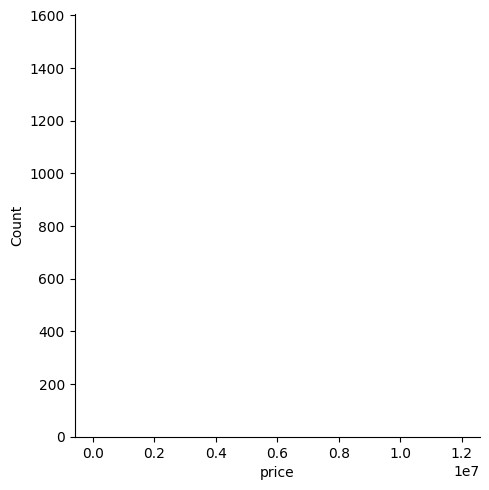

In [13]:
sns.displot(data=final_df, x='price')

In [14]:
final_df.to_parquet("releveant_ad.parquet")


# Experiment data

In [11]:
print(final_df["price"].quantile(0.95))
print(final_df["price"].quantile(0.05))


1300.0
20.0


In [12]:
USERS = (
    "roma_1",
    "roma_2",
    "roma_3",
    "roma_4",
    "kontrol_1",
    "kontrol_2",
    "kontrol_3",
    "kontrol_4",
)

PHONES = (
    "phone_1",
    # "phone_2",
)


In [13]:
(
    final_df.loc[
        lambda _df: (
            (_df["city_name"] == "Budapest")
            & (_df["price"] < _df["price"].quantile(0.95))
            & (_df["price"] > _df["price"].quantile(0.05))
        )
    ]
    .assign(quintil=lambda _df: pd.qcut(_df["price"], 5), n=1)
    .groupby(RealEstate.seller_id.id)
    .sample(1, random_state=42)
    .loc[lambda _df: (~_df[Seller.agency].duplicated()) | (~_df["is_agency"]), :]
    .pivot_table(index="is_agency", columns="quintil", values="n", aggfunc="count")
    # .sum(axis = 1)
)


quintil,"(20.198999999999998, 120.0]","(120.0, 200.0]","(200.0, 285.0]","(285.0, 440.0]","(440.0, 1299.0]"
is_agency,,,,,
False,845,727,400,334,286
True,124,237,170,219,209


In [14]:
SAMPLE_SIZE = 200
BATCH_SIZE = 100


In [15]:
import vobject

In [16]:
np.random.seed(42)
experiment_data = (
    final_df.loc[
        lambda _df: (
            (_df["city_name"] == "Budapest")
            & (_df["price"] < _df["price"].quantile(0.95))
            & (_df["price"] > _df["price"].quantile(0.05))
        )
    ]
    .groupby(RealEstate.seller_id.id)
    .sample(1, random_state=42)
    .loc[lambda _df: (~_df[Seller.agency].duplicated()) | (~_df["is_agency"]), :]
    # .groupby(["is_agency"])
    # .sample(int(SAMPLE_SIZE / 2), random_state=42)
    .sample(200, random_state=42) #TODO
    .sample(frac=1, random_state=42)
    .assign(
        exp_user=(USERS * (SAMPLE_SIZE // len(USERS) + 1))[:SAMPLE_SIZE],
    )
    .sample(frac=1, random_state=42)
    .assign(
        exp_phone=(PHONES * (SAMPLE_SIZE // len(PHONES) + 1))[:SAMPLE_SIZE],
    )
    .sample(frac=1, random_state=42)
    .assign(
        exp_phone=(PHONES * (SAMPLE_SIZE // len(PHONES) + 1))[:SAMPLE_SIZE],
    )
    .sample(frac=1, random_state=42)
    .groupby("exp_phone", group_keys=True)
    .apply(
        lambda _gdf: _gdf.assign(
            exp_batch=sorted(
                [*range((int(SAMPLE_SIZE / len(PHONES) / BATCH_SIZE)))] * BATCH_SIZE
            )
        )
    )
    .reset_index("exp_phone", drop=True)
    .sample(frac=1, random_state=42)
    .pipe(
        lambda _df: _df.groupby(
            _df["exp_user"].str.split("_").str[0], group_keys=True
        )
    )
    .apply(
        lambda gdf: gdf.assign(exp_msg=[*np.arange(0, 4)] * int(SAMPLE_SIZE / 2 / 4))
    )
    .reset_index("exp_user", drop=True)
)


In [17]:
# experiment_data.to_parquet('pre_trial.parquet')

In [18]:
pd.read_parquet("pre_trial.parquet")

,reference_id,seller_id__id,location_id__id,condition,area_size,type,price,address,phone_number,agency,name,is_agency,city_code,city_name,exp_user,exp_phone,exp_batch,exp_msg
property_id__id,,,,,,,,,,,,,,,,,,
33244403,None,3678,5377,looksLikeNew,90.0,flat,340.0,soroksári,+36 30 402 5319,Délcsillag Ingatlaniroda,Sternádné Szita Lívia,True,11,Budapest,kontrol_4,phone_1,0,0
33093340,None,205283379,135976,None,55.0,flat,155.0,XXIII. kerület Grassalkovich úti,+36 70 390 8006,None,nan,False,11,Budapest,kontrol_3,phone_1,0,1
33316714,None,212367487,135805,inGoodCondition,20.0,flat,110.0,XI. kerület Fehérvári úti,+36 30 604 8071,None,nan,False,11,Budapest,kontrol_1,phone_1,0,2
22687691,None,200889143,33385,inMediumCondition,33.0,flat,110.0,VII. kerület Csengery utcai,+36 30 699 5552,None,nan,False,11,Budapest,kontrol_1,phone_1,1,3
33146652,None,200481188,137663,renovated,52.0,flat,195.0,VIII. kerület Tömő utcai,+36 70 417 3967,None,nan,False,11,Budapest,kontrol_1,phone_1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33454334,None,201100073,136025,renovated,34.0,flat,160.0,IX. kerület Haller utcai,+36 70 428 3563,None,nan,False,11,Budapest,roma_1,phone_1,1,3
33297922,None,132028,32274,renovated,140.0,shop,499.0,VII. kerület Almássy téri,+36 70 387 9102,Ittislakhatok,Bátky Csaba,True,11,Budapest,roma_3,phone_1,0,0
33429925,COM 161530,136518,5178,looksLikeNew,48.0,flat,280.0,angyalföldi,+36 70 777 6342,Openhouse - Budapest Cityhome,Molnár Imre - Budapest IX.,True,11,Budapest,roma_2,phone_1,1,1


In [19]:
experiment_data.groupby("is_agency").size()
# experiment_data["exp_user"].value_counts()
# experiment_data["exp_phone"].value_counts()
# experiment_data["exp_batch"].value_counts()
# experiment_data["exp_msg"].value_counts()

is_agency
False    139
True      61
dtype: int64

In [20]:
USER_NAME_MAPPING = {
    "roma_1": ("Oláh", "László"),
    "roma_2": ("Kalányos", "János"),
    "roma_3": ("Orsós", "Attila"),
    "roma_4": ("Kolompár", "István"),
    "kontrol_1": ("Nagy", "Ferenc"),
    "kontrol_2": ("Molnár", "Tamás"),
    "kontrol_3": ("Varga", "Károly"),
    "kontrol_4": ("Tóth", "Zoltán"),
}

USER_MSG_MAPPING = {
    "roma": [Path(f'experiment/messages/roma_{x}.txt').read_text() for x in range(1, 5)],
    "kontrol": [Path(f'experiment/messages/kontrol_{x}.txt').read_text() for x in range(1, 5)],
}


In [21]:
experiment_data[["phone_number", "exp_user", "exp_phone", "exp_batch", "address", "exp_msg"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 33047202 to 33330198
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   phone_number  200 non-null    object
 1   exp_user      200 non-null    object
 2   exp_phone     200 non-null    object
 3   exp_batch     200 non-null    int64 
 4   address       200 non-null    object
 5   exp_msg       200 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 10.9+ KB


In [22]:
for (phone, batch), gdf in experiment_data[
    ["phone_number", "exp_user", "exp_phone", "exp_batch", "address", "exp_msg"]
].groupby(["exp_phone", "exp_batch"]):
    card_ls = []
    for prop_id, row in gdf.iterrows():
        first_name, last_name = USER_NAME_MAPPING[row["exp_user"]]
        msg = USER_MSG_MAPPING[row["exp_user"].split("_")[0]][row["exp_msg"]].format(
            address=row["address"], name=f"{first_name} {last_name}"
        )

        card = vobject.vCard()
        prop = card.add("fn")
        prop.value = f"id: {prop_id}"
        prop = card.add("n")
        prop.value = vobject.vcard.Name(family=str(prop_id), given=row['exp_user'])
        prop = card.add("tel")
        prop.type_param = "cell"
        prop.value = row["phone_number"]
        prop = card.add("org")
        prop.value = [msg]
        prop = card.add("note")
        prop.value = f"phone: {phone}; user: {row['exp_user']}, msg:{row['exp_msg']}"
        card_ls.append(card.serialize())

    # Path(f"experiment/contact/{phone}/{batch}.vcf").write_text(
    #     "\n".join(card_ls), encoding="utf-8"
    # )


In [23]:
"\n".join(card_ls)

'BEGIN:VCARD\r\nVERSION:3.0\r\nFN:id: 32402653\r\nN:32402653;roma_3;;;\r\nNOTE:phone: phone_1\\; user: roma_3\\, msg:2\r\nORG:Üdvözöm!  Az ingatlan.com-on láttam a székesdűlői kiadó lakást\r\n \\, és nagyon érdekelne. Valamelyik délután vagy este meg tudnám-e né\r\n zni munkaidő után? Még hozzátenném\\, hogy én roma származású vagy\r\n ok\\, remélem ez nem probléma. Köszönöm\\, Orsós Attila\r\nTEL;TYPE=cell:+36 70 777 6346\r\nEND:VCARD\r\n'

--------

In [ ]:
price_data = (
    price_df.loc[(slice(None), "HUF"), :]
    .loc[
        lambda _df: (
            (_df[Price.interval_d] == 0)
            & (_df[Price.interval_m] == 1)
            & (_df[Price.interval_y] == 0)
        ),
        Price.amount,
    ]
    .pipe(lambda _df: _df / 100)
    .sort_values()[lambda _s: _s < _s.quantile(0.99)]
    .reset_index(Price.currency, drop=True)
)


In [ ]:
agent_data = (
    seller_df[Seller.agency]
    .isna()
    .rename("is_agent")
    .map({True: "Individual", False: "Agent"})
)


In [ ]:
agent_data.value_counts()


In [ ]:
def get_district(loc_id: int):
    if location_df.loc[loc_id, "type"] == "district":
        return location_df.loc[loc_id, "name"]
    else:
        return get_district(int(location_df.loc[loc_id, "parent_id"]))


In [ ]:
property_df[property_df["subtype"] == "slipFormed"]


In [ ]:
district_data = (
    property_df[RealEstate.location_id.id].apply(get_district).rename("district")
)


In [ ]:
district_data


In [ ]:
analysis_data = (
    property_df.merge(price_data, left_index=True, right_index=True)
    .merge(agent_data, left_on=RealEstate.seller_id.id, right_index=True)
    .merge(district_data, left_index=True, right_index=True)
)


In [ ]:
sns.displot(
    analysis_data,
    x=RealEstate.subtype,
    hue="is_agent",
    multiple="dodge",
)


In [ ]:
sns.displot(
    analysis_data,
    x="district",
    hue="is_agent",
    multiple="dodge",
)


In [ ]:
sns.pairplot(
    analysis_data[[Price.amount, RealEstate.area_size, "is_agent"]], hue="is_agent"
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer


In [ ]:
logit = LogisticRegression()
ohe = OneHotEncoder(sparse=False)

transformer = ColumnTransformer(
    [("dummy", ohe, selector(dtype_include="object"))], remainder="passthrough"
)


In [ ]:
seller_df["agency"].nunique()


In [ ]:
833 * 2


# Agency

## Distrubuion of agency size

In [ ]:
data = seller_df[Seller.agency].value_counts()


In [ ]:
f"{data.shape[0]} agency in total with {data.values.mean():.4} member in average."


In [ ]:
fig = sns.displot(data=data.values, bins=10).set(
    title="Distrubuion of agency size", yscale="log", xticks=np.arange(0, 20, 5)
)
fig.savefig("output/agency_size.png")


# Prices

## Distribution of prices

In [ ]:
price_data = (
    price_df.loc[(slice(None), "HUF"), :]
    .loc[
        lambda _df: (
            (_df[Price.interval_d] == 0)
            & (_df[Price.interval_m] == 1)
            & (_df[Price.interval_y] == 0)
        ),
        Price.amount,
    ]
    .pipe(lambda _df: _df / 100)
    .sort_values()[lambda _s: _s < _s.quantile(0.99)]
    .reset_index(Price.currency, drop=True)
)


In [ ]:
fig = (
    sns.displot(data=price_data.values, bins=50)
    .set(title="Distribution of prices")
    .set(xlabel="Price (HUF)")
)
fig.savefig("output/price.png")


## Distribution of prices by seller type

In [ ]:
analysis_data = (
    price_data.to_frame()
    .reset_index(level=Price.currency)
    .join(
        (
            property_df[RealEstate.seller_id.id]
            .map(seller_df[Seller.agency].isna())
            .rename("is_agent")
            .map({True: "Individual", False: "Agent"})
        )
    )
)


In [ ]:
fig = (
    sns.displot(data=data, x=Price.amount, bins=50, hue="is_agent")
    .set(title="Distribution of prices by seller type")
    .set(xlabel="Price (HUF)")
)
fig.savefig("output/price_by_seller_type.png")


# Available from

In [ ]:
f"{property_df[RealEstate.available_from].isna().mean():.2%} available from now"


In [ ]:
property_df[RealEstate.available_from].dropna().sort_values()


# Sellers

## Offer count of users by user type

In [ ]:
data = (
    property_df.merge(
        seller_df[[Seller.agency]], left_on=RealEstate.seller_id.id, right_index=True
    )[Seller.agency].value_counts()
    #     .head(10)
)


In [ ]:
data[lambda _s: _s.index.str.startswith("Duna")]


In [ ]:
data = (
    property_df[RealEstate.seller_id.id]
    .value_counts()
    .to_frame()
    .join(
        (
            seller_df[Seller.agency]
            .isna()
            .rename("is_agent")
            .map({True: "Individual", False: "Agent"})
        )
    )
    .sort_values("is_agent", ascending=False)
)


In [ ]:
fig = sns.displot(
    data=data, x=RealEstate.seller_id.id, bins=10, hue="is_agent", multiple="dodge"
).set(
    title="Offer count of users by user type",
    xlabel="Offer count",
    ylabel="Users",
    yscale="log",
)
fig.savefig("output/offer_count_by_usertype.png")


# Contact

In [ ]:
seller_data = (
    contact_df.reset_index(Contact.phone_number)
    .join(property_df[[RealEstate.seller_id.id]])
    .merge(seller_df[Seller.agency], left_on=RealEstate.seller_id.id, right_index=True)
    .assign(
        is_agent=(
            lambda _df: _df[Seller.agency]
            .isna()
            .rename("is_agent")
            .map({True: "Individual", False: "Agent"})
        )
    )
)


In [ ]:
seller_data.groupby(Contact.phone_number)[Seller.agency].nunique(
    dropna=False
).sort_values()


In [ ]:
data = (
    seller_data.groupby(["is_agent", RealEstate.seller_id.id])[Contact.phone_number]
    .count()
    .sort_values()
    .rename("phone_count")
    .reset_index()
)


## Phone count of users by user type

In [ ]:
fig = sns.displot(
    data=data, x="phone_count", bins=10, hue="is_agent", multiple="dodge"
).set(
    title="Phone count of users by user type",
    xlabel="Phone count",
    ylabel="Users",
    yscale="log",
)
fig.savefig("output/user_phones_by_usertype.png")


## User count of phone number by user type

In [ ]:
property_df.shape


In [ ]:
x = seller_data.assign(
    phone_user_counts=lambda _df: (
        _df.groupby(Contact.phone_number)[RealEstate.seller_id.id].transform(
            pd.Series.nunique
        )
    ),
    phone_agency_counts=lambda _df: (
        _df.groupby(Contact.phone_number)[Seller.agency].transform(pd.Series.nunique)
    ),
)[lambda _df: (_df["phone_user_counts"] <= 1) & (_df["phone_agency_counts"] <= 1)]


In [ ]:
x.groupby("is_agent")["agency"].nunique()


In [ ]:
user_phones = (
    seller_data.groupby([Contact.phone_number, "is_agent"])[RealEstate.seller_id.id]
    .nunique()
    .rename("user_count")
    .reset_index()
)
# user_phones


In [ ]:
correct_phones = (
    user_phones[lambda _df: _df["user_count"] <= 1]
    .set_index(Contact.phone_number)
    .index
)


In [ ]:
seller_data[Contact.phone_number].isin(correct_phones).mean()


In [ ]:
seller_data_final = seller_data[
    lambda _df: _df[Contact.phone_number].isin(correct_phones)
]


In [ ]:
user_phones[lambda _df: _df["user_count"] == 1]


In [ ]:
fig = sns.displot(
    data=user_phones, x="user_count", hue="is_agent", multiple="dodge", bins=10
).set(
    title="User count of phone number by user type",
    xlabel="User count",
    ylabel="Phone numbers",
    yscale="log",
)
fig.savefig("output/phone_users_by_usertype.png")


In [ ]:
x = seller_data_final["phone_number"].iloc[0]


In [ ]:
import re


In [ ]:
phone_regex = re.compile(
    r"^\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*$"
)


In [ ]:
x


In [ ]:
phone_regex.search(x)
